In [2]:
import subprocess
import requests
import pandas as pd
import json

# User data

## Calories

In [3]:
def parse(url):    
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
    else:
        print(f"Failed to fetch data, status code: {response.status_code}")
        return None
    structured_nutrients = []

    # Iterate over each day in the data
    for day, content in data['week'].items():
        # Extract nutrients data and include the day of the week
        nutrients_data = {
            'Day': day.capitalize(),
            'calories': content['nutrients']['calories'],
            'Protein': content['nutrients']['protein'],
            'Fat': content['nutrients']['fat'],
            'Carbohydrates': content['nutrients']['carbohydrates']
        }
        # Append the nutrients data to the list
        structured_nutrients.append(nutrients_data)

    # Convert the list of nutrients data into a DataFrame
    user_cal = pd.DataFrame(structured_nutrients)
    user_cal = user_cal[["calories"]]
    return user_cal

## Converter with other variables

In [4]:
# this function is use to convert the planned workout session into binary variables for prediction

def convert(url, walk_days, run_days, weights_days, wine_days):
    user_cal = parse(url)
    # get function for url
    week = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
    walk = []
    run = []
    wine = []
    weights = []

    for day in week:
        if day in walk_days:
            walk.append(1)
        else:
            walk.append(0)

    for day in week:
        if day in run_days:
            run.append(1)
        else:
            run.append(0)

    for day in week:
        if day in wine_days:
            wine.append(1)
        else:
            wine.append(0)

    for day in week:
        if day in weights_days:
            weights.append(1)
        else:
            weights.append(0)

    user_rhy = pd.DataFrame({
                        'walk': walk,
                        'run': run,
                        'wine': wine,
                        'weight': weights})
    
    user_data = pd.concat([user_cal,user_rhy], axis=1)
    user_data.reset_index(drop=True, inplace=True)
    user_data.index = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
    return user_data

# Predition

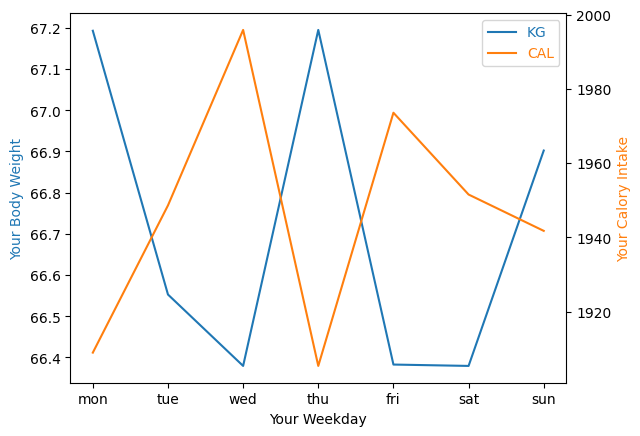

In [8]:
import requests
import pickle
from io import BytesIO

#Sample  #cal
url_user = "https://api.spoonacular.com/mealplanner/generate?apiKey=4deaceca7a6448ba9d2006710177aad3&timeframe=week&diet=vegetarian"

# Sample user inpput
user_input1 = ["tue", "thu", "sun"] #walk
user_input2 = ["mon", "thu", "sun"] #run
user_input3  = ["tue", "wed", "sat"] #wine
user_input4  = ["tue", "fri", "sun"] #weight
user_weight = 65

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def pred(url_user, user_input1, user_input2, user_input3, user_input4, weight):
    url = "https://github.com/calvinkochunisg/HSG-CS-Project/raw/dev/Data/model.sav"
    user_data = convert(url_user, user_input1, user_input2, user_input3, user_input4)
    weight_diff = 76.253 - weight
    
    response = requests.get(url)
    if response.status_code == 200:
        model_data = BytesIO(response.content)
        loaded_model = pickle.load(model_data)
        #adjusted weight
        prediction = loaded_model.predict(user_data) - weight_diff
        pred = pd.DataFrame(prediction, columns=['pred'])
        pred.reset_index(drop=True, inplace=True)
        pred.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

        host = host_subplot(111)
        par = host.twinx()

        host.set_xlabel("Your Weekday")
        host.set_ylabel("Your Body Weight")
        par.set_ylabel("Your Calory Intake")

        p1, = host.plot(user_data.index, pred, label="KG")
        p2, = par.plot(user_data.index, user_data["calories"], label="CAL")

        host.legend(labelcolor="linecolor")

        host.yaxis.get_label().set_color(p1.get_color())
        par.yaxis.get_label().set_color(p2.get_color())

        #plt.show()

    else:
        print("Failed to download the file. Status code:", response.status_code)

    return host 

prediction = pred(url_user, user_input1, user_input2, user_input3, user_input4,67)
